_python notebook №2_

## Стадия обученяи сетей ResNet18 с применением Transfer learning

In [1]:
#pip install nbimporter

In [1]:
import nbimporter
import datasets_bilder # загрузка datasets_bilder.py из репозитория

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import seaborn as sns
import torch,torchvision
from  matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import torchvision.utils as vutils
%matplotlib inline

In [3]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [4]:
print('В репозитории находятся следующие файлы:', os.listdir())

В репозитории находятся следующие файлы: ['.git', '.gitignore', '.ipynb_checkpoints', 'chest_xray', 'datasets_bilder.py', 'models', 'Preprocessing_&_custom_DL_model.ipynb', 'Transfer_learning_ResNet_training.ipynb', '__pycache__']


Для реализации предобработки данных я написал отельный файл datasets_bilder.py в котором описал создание класса preprocessing_func, который в методе init генерит 3 датасета: dataset_test, dataset_train, dataset_test и сохраняет их значения в атрибутах test, train, val объекта класса. Атрибуты mean_nums и std_nums дают возможность получить величины средних значений и ско для всего train датасета. <br><br>
По сути данный код является полной копией кода из файла Preprocessing_&_custom_DL_model.ipynb, но только представленным в виде функции инициализации объекта класса. Так что для ознакомления с реализацией предобработки советую рассмотреть тот python notebook.<br> <br>
Единственным важным дополнением в предобработке, представленной в файле datasets_bilder.py, можно назвать возможность выбора размерности данных, которые мы хотим получать на выходе. Если при задании объекта класса указать значение size, то можно самому выбрать размер получаемых после трасформации Resize изображений (по умолчанию - квадратные изображения размером 224 на 224). <br>Так же если ввести при задании объекта значение RGB_presentation = True, то выходной размер изображений станет равен (3, Size, Size) вместо классического для чб снимков тензора размером (1, Size, Size). По умолчанию RGB_presentation = False. Данная функция будет нужна при Transfer Learning, так как предобученные сети имеют первый сверточный слой трехканальным, так что для использования готовых сетей можно просто сделать дублирование одного канала еще 2 раза чтобы изображение черно-белое можно было считать цветным. При выборе RGB_presentation = True тензоры, хранящиеся в атрибутах mean_nums и std_nums тоже меняют размерность
<br> Параметр easy = True позволяет трейновый датасет сделать размером 5370 изображений (применяется 2 трансформации вместо 4) По умолчанию параметр стоит False => 10740 изображений

__Пример работы с preprocessing_func:__

In [29]:
data = datasets_bilder.preprocessing_func(size = 100, RGB_presentation = True)

In [30]:
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums

In [31]:
mean_nums, std_nums

(tensor([0.5455, 0.5455, 0.5455]), tensor([0.2587, 0.2587, 0.2587]))

In [32]:
a, _ = dataset_test[0]
a.shape

torch.Size([3, 100, 100])

Зададим вычислительное устройство:

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [52]:
batch_size = 8 # зададим размер батча

Проверим правильность загруженных данных:

In [4]:
def imshow(img):
    img = img *std_nums[0] + mean_nums[0]  
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    plt.show()

In [59]:
dataloader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test:


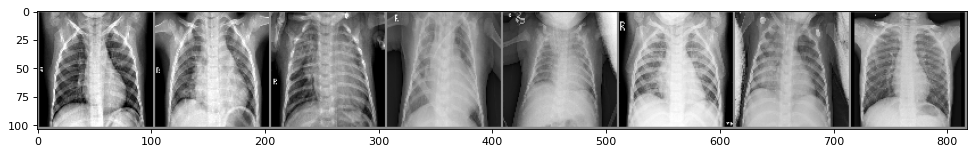

GroundTruth:  norm,  pneumonia,  pneumonia,  pneumonia,  pneumonia,  norm,  pneumonia,  norm


In [60]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(dataloader_test))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)
print('test:')
plt.figure(figsize=(15, 9), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=8))
print('GroundTruth: ', ',  '.join( classes[int(label_batch[j])] for j in range(batch_size)))

Функция для визуализации confusion_matrix:

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## ResNet18

Загрузим предобученную модель. У нее входной первый сверточный слой является трехканальным размером 224 на 224 пикселя. Сама сетка имеет 18 слоев.

In [7]:
from torchvision.models import resnet18, ResNet18_Weights

In [110]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

У данной сети представлен лишь 1 слой полносвязный под названием fc с выходным числом нейронов равным 1000. В нашем случае решается задача бинарной классификации, так что данный слой будет иметь по 2 нейрона на выходе.

## _Рассмотрим какие эксперименты мы будем проводить с данной сетью:_

__1) Зафиксируем полностью все сверточные слои и лишь обучим полносвязные слои.__ <br>При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра.  Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

__2) Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


__3) Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__<br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

## №1

In [107]:
data = datasets_bilder.preprocessing_func(RGB_presentation = True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums

In [111]:
n_neurons = 100

In [112]:
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))

In [113]:
model.fc = fc_new
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [119]:
# Зафиксируем все слои кроме переназначенного fc
for name, param in model.named_parameters():
    if not ('fc' in name):
        param.requires_grad = False

Опишем такие же прарметры обучения как в python notebook №1:

In [120]:
loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

Создадим папку, куда загрузим модели:

In [122]:
directory = os.getcwd() + '\models'
if not os.path.exists(directory):
    os.makedirs(directory)

Сделаем тренировочный запуск обучения без подбора гиперпараметров. Сам принцип кода по обучению такой же, как был при обучении кастомной нейросетки в прошлом ноутбуке №1

In [123]:
n_epoch = 2 #Зададим число эпох обучения
batch_size = 10 #Размер батча

In [145]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [127]:
# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

model.train() # Перевод модели в режим обучения
start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model, directory+'\model_TransferLearning.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [46:48<00:00,  2.62s/it]


[epoch 1] loss: 0.387, acc: 0.825
Validation accuracy - 0.878125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [46:43<00:00,  2.61s/it]


[epoch 2] loss: 0.368, acc: 0.839
Validation accuracy - 0.8999999999999999
Total time 5752.861 seconds


In [133]:
wghts = torch.load(directory + '/model_TransferLearning.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

In [147]:
model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 86.88 %


In [137]:
y_pred_list = np.asarray(y_pred_list).flatten()
y_true_list = np.asarray(y_true_list).flatten()
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       129
           1       0.90      0.87      0.89       191

    accuracy                           0.87       320
   macro avg       0.86      0.87      0.86       320
weighted avg       0.87      0.87      0.87       320



Получили довольно высокие результаты всего лишь при двух эпохах обучения.<br>

---

__Теперь проведем обучение 10 эпох для каждого значения подбираемого гиперпараметра:__

Я сделаю один скрытый слой в новом fc layer с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определю по результатам accuracy на валидационной выборке + построю графики изменения метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра. <br> Значения пербираемые n_neurons = 10, 100 и 500

In [8]:
n_neurons_list = [10, 100, 500]

In [9]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True, easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 10 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [13]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [15]:
# Задаим словари для отслеживания метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра.
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}

n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in n_neurons_list:
    model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
    model.fc = fc_new
    # Зафиксируем все слои кроме переназначенного fc
    for name, param in model.named_parameters():
        if not ('fc' in name):
            param.requires_grad = False
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)
    
    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []
    
    
    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model, directory+'\model_ResNet18_1_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:05<00:00,  2.58s/it]


[epoch 1] loss: 0.307, acc: 0.881
Validation accuracy - 0.8843749999999999


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:09<00:00,  2.59s/it]


[epoch 2] loss: 0.219, acc: 0.918
Validation accuracy - 0.871875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:00<00:00,  2.57s/it]


[epoch 3] loss: 0.205, acc: 0.921
Validation accuracy - 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:01<00:00,  2.57s/it]


[epoch 4] loss: 0.199, acc: 0.92
Validation accuracy - 0.8625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:03<00:00,  2.58s/it]


[epoch 5] loss: 0.195, acc: 0.922
Validation accuracy - 0.896875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:54<00:00,  2.56s/it]


[epoch 6] loss: 0.171, acc: 0.934
Validation accuracy - 0.878125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.53s/it]


[epoch 7] loss: 0.163, acc: 0.936
Validation accuracy - 0.8656250000000001


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 8] loss: 0.167, acc: 0.934
Validation accuracy - 0.846875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 9] loss: 0.165, acc: 0.933
Validation accuracy - 0.853125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:35<00:00,  2.52s/it]


[epoch 10] loss: 0.178, acc: 0.929
Validation accuracy - 0.8531249999999999
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 1] loss: 0.269, acc: 0.891
Validation accuracy - 0.89375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 2] loss: 0.228, acc: 0.909
Validation accuracy - 0.865625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.54s/it]


[epoch 3] loss: 0.192, acc: 0.922
Validation accuracy - 0.86875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:44<00:00,  2.54s/it]


[epoch 4] loss: 0.195, acc: 0.922
Validation accuracy - 0.8593749999999999


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 5] loss: 0.191, acc: 0.926
Validation accuracy - 0.81875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 6] loss: 0.161, acc: 0.936
Validation accuracy - 0.86875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 7] loss: 0.144, acc: 0.943
Validation accuracy - 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:45<00:00,  2.54s/it]


[epoch 8] loss: 0.148, acc: 0.94
Validation accuracy - 0.8625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.54s/it]


[epoch 9] loss: 0.144, acc: 0.942
Validation accuracy - 0.865625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 10] loss: 0.138, acc: 0.946
Validation accuracy - 0.871875
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:55<00:00,  2.56s/it]


[epoch 1] loss: 0.274, acc: 0.886
Validation accuracy - 0.853125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:53<00:00,  2.56s/it]


[epoch 2] loss: 0.244, acc: 0.902
Validation accuracy - 0.871875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.54s/it]


[epoch 3] loss: 0.206, acc: 0.917
Validation accuracy - 0.846875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:35<00:00,  2.52s/it]


[epoch 4] loss: 0.208, acc: 0.915
Validation accuracy - 0.853125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:35<00:00,  2.53s/it]


[epoch 5] loss: 0.18, acc: 0.928
Validation accuracy - 0.853125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.53s/it]


[epoch 6] loss: 0.138, acc: 0.947
Validation accuracy - 0.84375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:45<00:00,  2.54s/it]


[epoch 7] loss: 0.139, acc: 0.948
Validation accuracy - 0.865625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:48<00:00,  2.55s/it]


[epoch 8] loss: 0.139, acc: 0.943
Validation accuracy - 0.865625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:44<00:00,  2.54s/it]


[epoch 9] loss: 0.139, acc: 0.947
Validation accuracy - 0.865625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:46<00:00,  2.54s/it]


[epoch 10] loss: 0.137, acc: 0.949
Validation accuracy - 0.8812499999999999
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500
Total time 43063.5 seconds


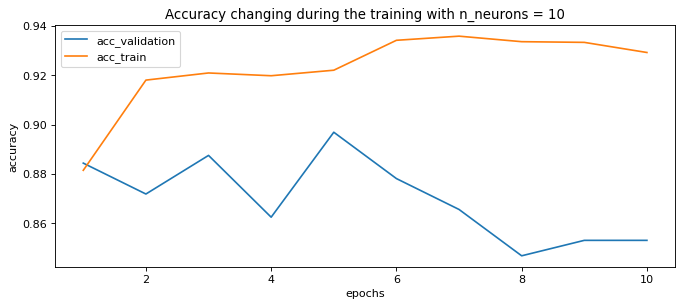

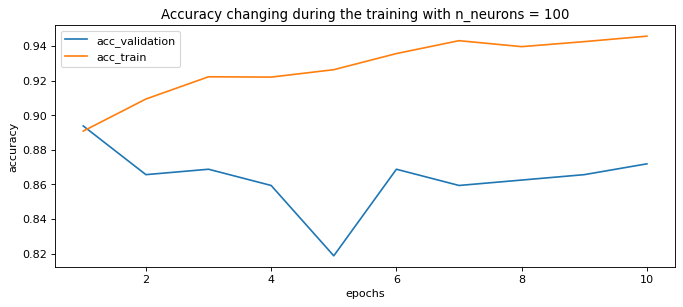

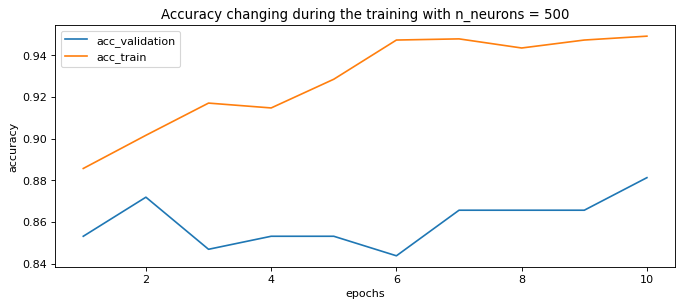

In [16]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

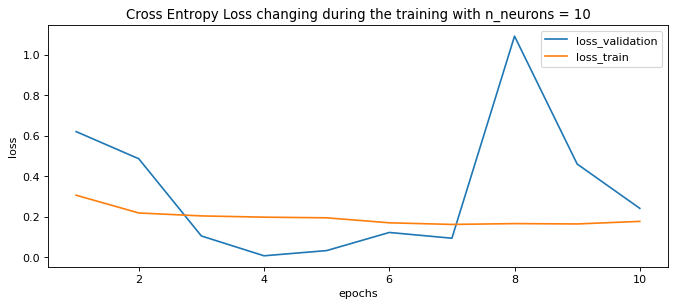

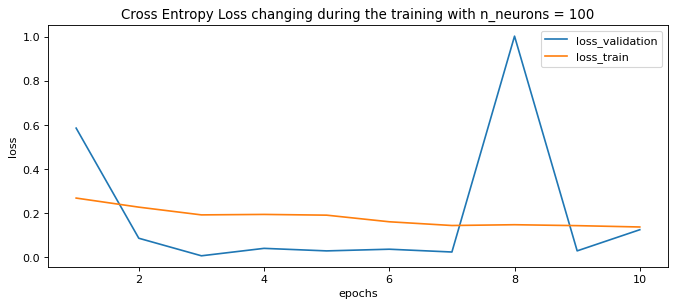

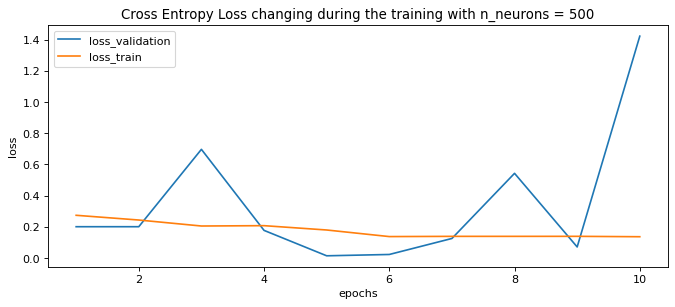

In [17]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

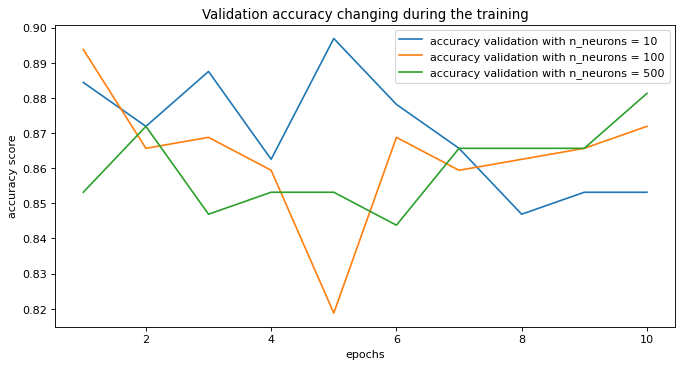

In [18]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

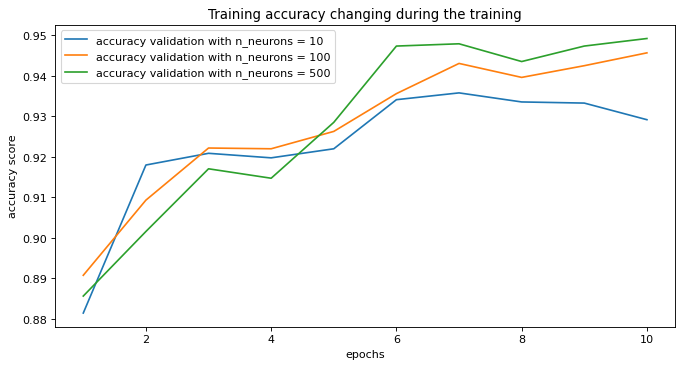

In [23]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_train = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [20]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

Validation accuracy change:


,epoch,10 neurons,100 neurons,500 neurons
0,1.0,0.884375,0.893750,0.853125
1,2.0,0.871875,0.865625,0.871875
2,3.0,0.887500,0.868750,0.846875
3,4.0,0.862500,0.859375,0.853125
4,5.0,0.896875,0.818750,0.853125
5,6.0,0.878125,0.868750,0.843750
6,7.0,0.865625,0.859375,0.865625
7,8.0,0.846875,0.862500,0.865625
8,9.0,0.853125,0.865625,0.865625
9,10.0,0.853125,0.871875,0.881250


In [21]:
acc_validation_dict_1 = acc_validation_dict
acc_train_dict_1 = acc_train_dict

Самый высокий показатель accuracy на валидации показал гиперпараметр 10 на 4 эпохе обучения. Так что загрузим именно эту модель:

In [43]:
n_neurons = 10
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
model.fc = fc_new
wghts = torch.load(directory + '\model_ResNet18_1_n='+str(n_neurons)+'.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Оценим качество этой модели на test:

In [44]:
model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 86.56 %


In [45]:
y_pred_list = np.asarray(y_pred_list).flatten()
y_true_list = np.asarray(y_true_list).flatten()
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       129
           1       0.89      0.88      0.89       191

    accuracy                           0.87       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.87      0.87      0.87       320



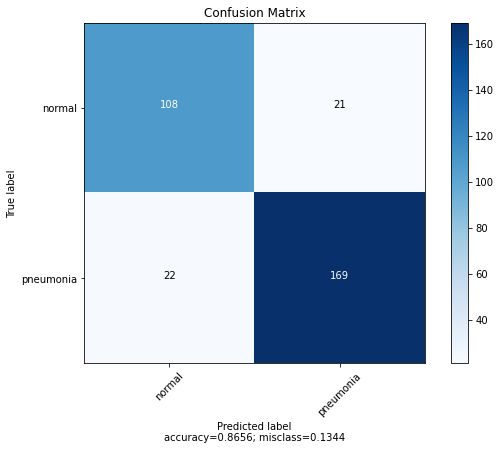

In [46]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


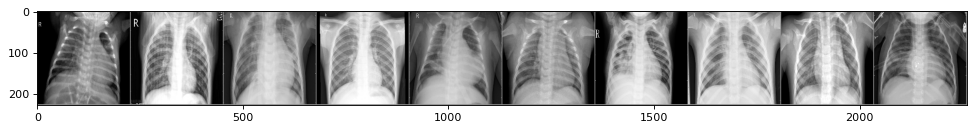

GroundTruth:  pneumonia pneumonia pneumonia  norm pneumonia  norm pneumonia pneumonia  norm pneumonia
Прогноз:  norm pneumonia pneumonia pneumonia pneumonia norm pneumonia pneumonia norm pneumonia


In [47]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

---

## №2

__Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


In [48]:
data = datasets_bilder.preprocessing_func(easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 10 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [49]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [51]:
n_neurons_list = [10, 100, 500]

In [ ]:
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}

n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in n_neurons_list:
    model_2 = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
    # Переопределим первый сверточный слой сети, сделав 1 входной канал
    model_2.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
    model_2.fc = fc_new
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model_2.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)
    
    
    # Зафиксируем все слои кроме переназначенного fc  и conv1
    for name, param in model_2.named_parameters():
        if not (('conv1' in name) or ('fc' in name)):
            param.requires_grad = False

    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []

    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model_2.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model_2(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model_2.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model_2(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model_2, directory+'\model_ResNet18_2_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


  2%|██                                                                                             | 12/537 [00:08<05:43,  1.53it/s]

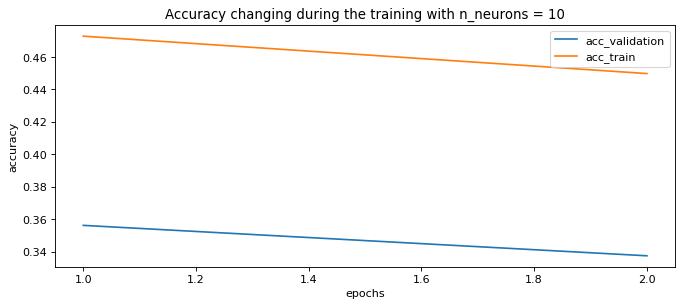

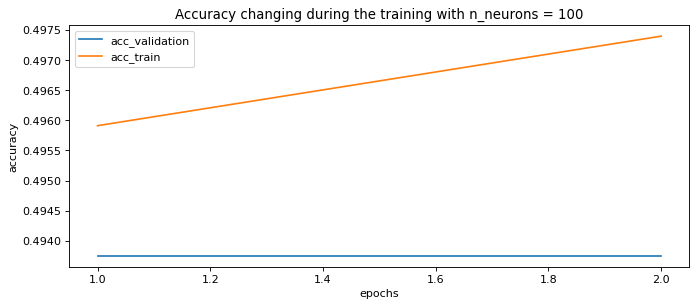

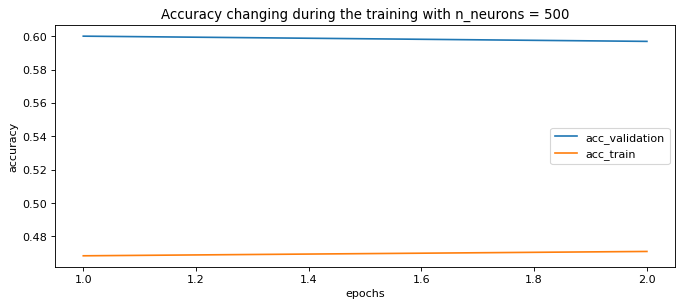

In [41]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

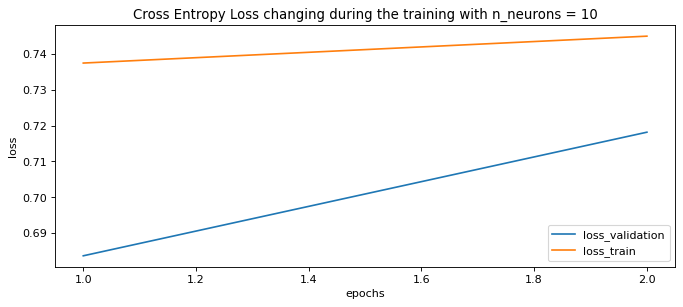

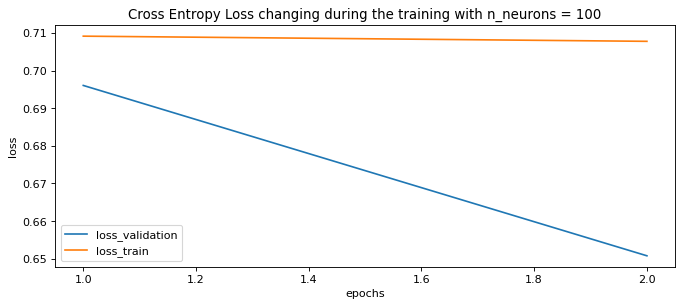

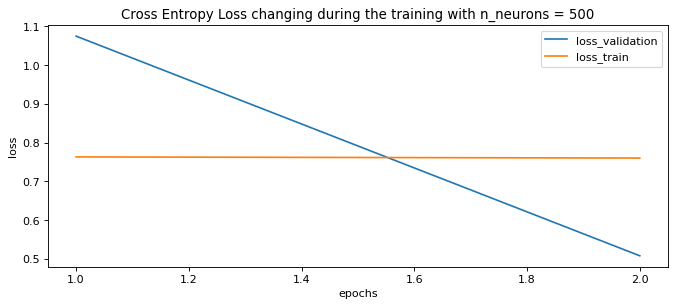

In [42]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

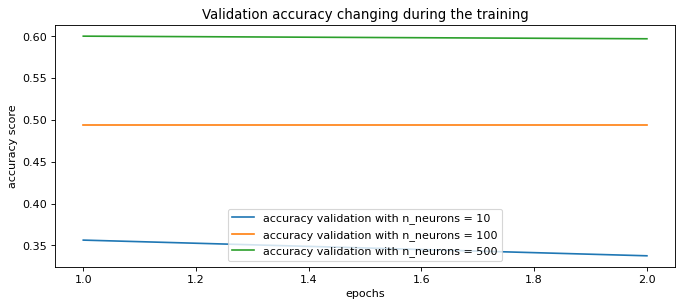

In [43]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

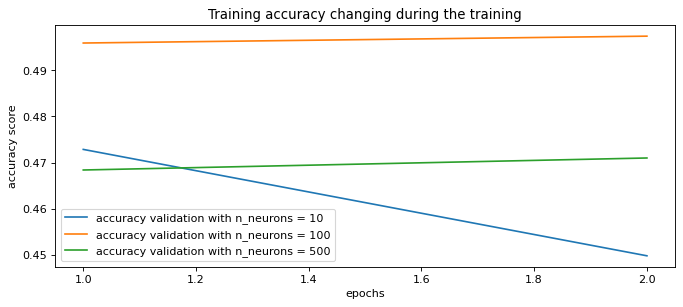

In [46]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_train = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [47]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

Validation accuracy change:


,epoch,10 neurons,100 neurons,500 neurons
0,1.0,0.35625,0.49375,0.600000
1,2.0,0.33750,0.49375,0.596875


Самый высокий показатель accuracy на валидации показал гиперпараметр 33333333 на3 333334 эпохе обучения. Так что загрузим именно эту модель:

In [43]:
n_neurons = 11111111
model_2 = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# Переопределим первый сверточный слой сети, сделав 1 входной канал
model_2.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
model_2.fc = fc_new
wghts = torch.load(directory + '\model_ResNet18_1_n='+str(n_neurons)+'.pth')
model_2.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Оценим качество этой модели на test:

In [ ]:
model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model_2(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

In [ ]:
y_pred_list = np.asarray(y_pred_list).flatten()
y_true_list = np.asarray(y_true_list).flatten()
print(classification_report(y_true_list, y_pred_list))

In [ ]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

In [ ]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model_2(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

## №3

__Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__ <br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

In [48]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 10 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [49]:
n_epoch = 15

In [50]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [51]:
model_3 = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)

# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(512, 2))
model_3.fc = fc_new
    
for name, param in model_3.named_parameters():
    param.requires_grad = True

loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model_3.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)   

# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    model_3.train() # Перевод модели в режим обучения
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model_3(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model_3.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model_3(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model_3, directory+'\model_ResNet18_full_train.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [13:29<00:00,  3.01s/it]


[epoch 1] loss: 0.71, acc: 0.512
Validation accuracy - 0.703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [13:22<00:00,  2.98s/it]


[epoch 2] loss: 0.706, acc: 0.525
Validation accuracy - 0.70625
Total time 1750.095 seconds
